# Uncapacitated Facility Location Problem
## Setup

In [31]:
# import
from pulp import *
from solver_utils import *
from data_utils import *
import numpy as np

%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.size'] = 12
plt.style.use('seaborn-white')

# services
Data = DataGenerator()
Log = DataLogger()

## Primal Model

In [2]:
def build_primal(c_num, l_num, C, F):
    # problem instance
    problem = LpProblem("UFL - Primal Problem (Wolsey)", sense=LpMaximize)

    # decision variables
    x = Data.VAR_matrix(c_num, l_num, 'x', 'Continuous')
    y = Data.VAR_vector(l_num, 'y', 'Binary')

    # objective function
    profits = [C[i][j] * x[i][j] for i in range(c_num) for j in range(l_num)]
    fixed_costs = [F[j] * y[j] for j in range(l_num)]
    problem += lpSum(profits) - lpSum(fixed_costs)

    # constraints
    for i in range(c_num):
        problem += lpSum([x[i][j] for j in range(l_num)]) == 1

    for i in range(c_num):
        for j in range(l_num):
            problem += x[i][j] - y[j] <= 0
            
    return problem

## Primal Integer Problem

In [3]:
def build_primal_int(c_num, l_num, C, F):
    # problem instance
    problem = LpProblem("UFL - Primal Problem (Wolsey)", sense=LpMaximize)

    # decision variables
    x = Data.VAR_matrix(c_num, l_num, 'x', 'Continuous')
    y = Data.VAR_vector(l_num, 'y', 'Continuous')

    # objective function
    profits = [C[i][j] * x[i][j] for i in range(c_num) for j in range(l_num)]
    fixed_costs = [F[j] * y[j] for j in range(l_num)]
    problem += lpSum(profits) - lpSum(fixed_costs)

    # constraints
    for i in range(c_num):
        problem += lpSum([x[i][j] for j in range(l_num)]) == 1

    for i in range(c_num):
        for j in range(l_num):
            problem += x[i][j] - y[j] <= 0
            
    return problem

## Relaxed Model

In [4]:
def build_relaxed(c_num, l_num, u_vector, C, F):
    """
    Lagrange relaxation for UFL problem as in Wolsey
    """

    # problem instance
    problem = LpProblem("UFL - Lagrange Relaxed Problem (Wolsey)", sense=LpMaximize)

    # check lagrange multipliers vector
    if len(u_vector) != c_num : 
        raise ValueError('Invalid u_vect size')

    # decision variables    
    x = Data.VAR_matrix(c_num, l_num, 'x', 'Continuous')
    y = Data.VAR_vector(l_num, 'y', 'Binary')

    # objective function
    profits = [C[i][j] * x[i][j] for i in range(c_num) for j in range(l_num)]
    fixed_costs = [F[j] * y[j] for j in range(l_num)]
    l1 = [u_vector[i] for i in range(c_num)]
    l2 = [u_vector[i] * x[i][j] for i in range(c_num) for j in range(l_num)]
    #lagrange = [u_vector[i] * (1 - x[i][j]) for i in range(c_num) for j in range(l_num)]

    problem += lpSum(profits) - lpSum(fixed_costs) + lpSum(l1) - lpSum(l2)

    # constraints
    for i in range(c_num):
        for j in range(l_num):
            problem += x[i][j] - y[j] <= 0

    return problem

## Subgradient Algorithm
#### Version 1 (course material)

In [5]:
def run_subgradient(c_num, l_num, u_vector, z_ip, C, F):
    # parameters
    t_max = c_num # maximum loops w/ improvement
    k = 1 # no improvement loop counter
    alpha_stop = 0.05 # stop parameter
    alpha = 2
    z_best = np.Infinity
    p_lr_best = None

    while True:
        # compute best z(u)
        p_lr = build_relaxed(c_num, l_num, u_vector, C, F)
        solve(p_lr)
        z_lr = get_objectiveFunction_value(p_lr)
        Log.logData('z_lr', z_lr)
        Log.logData('z_ip', z_ip) # simplify plotting

        # compute subgradient
        x_lr = get_variable_value(p_lr, 'x')
        # print(f"x_lr:\n {x_lr}")
        sg = subgradient_tbn(x_lr, c_num, l_num)
        # print(f"subgradient vector:\n {sg}")

        # check subgradient
        if not np.any(sg):
            print(f"null subgradient:\n {sg}")
            p_lr_best = p_lr
            break

        # compute step size            
        step = step_tbn(alpha, z_ip, z_lr, sg)
        
        # compute new lagrange multipliers
        u = u_vector #copy
        u_vector = update_lagrange_tbn(u, step, sg)

        # check bound
        if round(z_lr, 3) < round(z_best, 3):
            z_best = z_lr
            p_lr_best = p_lr
            k = 0
            print(f"z_best: {z_best}")
            
        # check counter
        if k == t_max:
            alpha = alpha / 2
            k = 0
            print(f"alpha: {alpha}")

        # check stop condition
        if alpha < alpha_stop:
            break
        
        k = k + 1
    return (z_best, p_lr_best)

#### Version 2 (paper)

In [6]:
def run_subgradient_paper(c_num, l_num, u_vector, z_ip, C, F):
    # parameters
    t_max = c_num # maximum loops w/ improvement
    k = 1 # no improvement loop counter
    alpha_stop = 0.05 # stop parameter
    alpha = 2
    z_best = np.Infinity
    p_lr_best = None

    while True:
        # compute best z(u)
        p_lr = build_relaxed(c_num, l_num, u_vector, C, F)
        solve(p_lr)
        z_lr = get_objectiveFunction_value(p_lr)
        Log.logData('z_lr2', z_lr)
        Log.logData('z_ip2', z_ip) # simplify plotting

        # compute subgradient
        x_lr = get_variable_value(p_lr, 'x')
        # print(f"x_lr:\n {x_lr}")
        sg = subgradient_tbn(x_lr, c_num, l_num)
        # print(f"subgradient vector:\n {sg}")

        # check subgradient
        if not np.any(sg):
            print(f"null subgradient:\n {sg}")
            p_lr_best = p_lr
            break

        # compute step size            
        step = step_paper(alpha, z_ip, z_lr, sg)
        
        # compute new lagrange multipliers
        u = u_vector #copy
        u_vector = update_lagrange_paper(u, step, sg)

        # check bound
        if round(z_lr, 3) < round(z_best, 3):
            z_best = z_lr
            p_lr_best = p_lr
            k = 0
            print(f"z_best: {z_best}")
            
        # check counter
        if k == t_max:
            alpha = alpha / 2
            k = 0
            print(f"alpha: {alpha}")

        # check stop condition
        if alpha < alpha_stop:
            break
        
        k = k + 1
    return (z_best, p_lr_best)

### Compute subgradient vector

In [7]:
def subgradient_tbn(x_lr, c_num, l_num):
    # reshape X matrix
    x_lr = np.reshape(x_lr, (c_num, l_num)) 

    # compute D*x(u)
    d_x = [sum([x_lr[i][j] for j in range(l_num)]) for i in range(c_num)]
    # print(x_lr)
    # print(d_x)

    # d vector
    d = np.ones(c_num)

    # subgradient
    sg = d - d_x
    #print(f"subgradient: \n{sg}")

    return sg

### Compute step size
#### Version 1 (course material)

In [8]:
def step_tbn(alpha, z_ip, z_lr, subgradient):
    num = np.abs(z_ip - z_lr)
    den = (np.linalg.norm(subgradient)) ** 2
    step = alpha * num / den
    
    # log data
    Log.logData('step_size', step)
    Log.logData('alpha', alpha)

    #print(f"step_tbn: {step}")
    return step

#### Version 2 (paper)

In [9]:
def step_paper(alpha, z_ip, z_lr, subgradient):
    num = np.abs(z_ip - z_lr)
    den = np.sum(np.square(subgradient))
    step = alpha * num / den
    
    # log data
    Log.logData('step_size2', step)
    Log.logData('alpha2', alpha)

    #print(f"step_tbn: {step}")
    return step

### Compute new Lagrange multipliers vector
#### Version 1 (course material)

In [10]:
def update_lagrange_tbn(u, step, subgradient):
    u_next = u + step * subgradient

    #print(f"u_next_tbn: \n{u_next}")
    return u_next

#### Version 2 (paper)

In [11]:
def update_lagrange_paper(u, step, subgradient):
    size = len(subgradient)
    u_vect = [min(0, u[i] + step * subgradient[i]) for i in range(size)]
        
    u_next = np.asarray(u_vect)
    #print(f"u_next_tbn: \n{u_next}")
    return u_next

## Results
### Run

In [12]:
def runner(c_num=10, l_num=2):    
    # init c_num revenues
    C = Data.INT_matrix(c_num, l_num, False)

    # init facilities service cost
    f_avg_profit = np.average(C) # avg facility profit   
    f_min_cost = f_avg_profit
    f_max_cost = f_avg_profit * c_num * 2
    F = Data.INT_vector(l_num, f_min_cost, f_max_cost, False)
    #print(f"C:\n {C}")
    #print(f"F:\n {F}")
    
    # lagrange multipliers
    u_vector = np.zeros(c_num)
    
    
    
    # IP problem      
    ip_problem = build_primal(c_num, l_num, C, F)
    print("####################")
    print("SOLVE PRIMAL PROBLEM")
    
    solve(ip_problem, console_out=False)
    pY = get_variable_value(ip_problem, 'y')
    pX = get_variable_value(ip_problem, 'x').reshape(c_num, l_num)
    pZ = get_objectiveFunction_value(ip_problem)    
    print(f"pY = {pY}")
    #print(f"pX = \n {pX}")
    print(f"pZ = {pZ}")
    print("####################\n\n")
    
    # IP problem      
    ip_problem_int = build_primal_int(c_num, l_num, C, F)
    print("####################")
    print("SOLVE PRIMAL INTEGER PROBLEM")
    
    solve(ip_problem, console_out=False)
    pY = get_variable_value(ip_problem, 'y')
    pX = get_variable_value(ip_problem, 'x').reshape(c_num, l_num)
    pZ = get_objectiveFunction_value(ip_problem)    
    print(f"pY = {pY}")
    #print(f"pX = \n {pX}")
    print(f"pZ = {pZ}")
    print("####################\n\n")
    
    
    # LR problem (tbn)
    print("####################")
    print("SOLVE RELAXED PROBLEM (Subgradient Ver. 1)")    
    
    (rZ, rP) = run_subgradient(c_num, l_num, u_vector, pZ, C, F)
    rY = get_variable_value(rP, 'y')
    rX = get_variable_value(rP, 'x').reshape(c_num, l_num)
    print(f"rY = {rY}")
    #print(f"rX = \n {rX}")
    print(f"rZ = {rZ}")
    print("####################\n\n")
    
    # LR problem (tbn)
    print("####################")
    print("SOLVE RELAXED PROBLEM (Subgradient Ver. 2)")    
    
    (r2Z, r2P) = run_subgradient_paper(c_num, l_num, u_vector, pZ, C, F)
    r2Y = get_variable_value(r2P, 'y')
    r2X = get_variable_value(r2P, 'x').reshape(c_num, l_num)
    print(f"r2Y = {r2Y}")
    #print(f"rX = \n {rX}")
    print(f"r2Z = {r2Z}")
    print("####################\n\n")


# Run command
runner(25, 3)

####################
SOLVE PRIMAL PROBLEM
pY = [0. 1. 1.]
pZ = 127.0
####################


####################
SOLVE PRIMAL INTEGER PROBLEM
pY = [0. 1. 1.]
pZ = 127.0
####################


####################
SOLVE RELAXED PROBLEM (Subgradient Ver. 1)
z_best: 177.0
alpha: 1.0
alpha: 0.5
alpha: 0.25
alpha: 0.125
alpha: 0.0625
alpha: 0.03125
rY = [0. 1. 1.]
rZ = 177.0
####################


####################
SOLVE RELAXED PROBLEM (Subgradient Ver. 2)
z_best: 177.0
alpha: 1.0
alpha: 0.5
alpha: 0.25
alpha: 0.125
alpha: 0.0625
alpha: 0.03125
r2Y = [0. 1. 1.]
r2Z = 177.0
####################




### Plot results

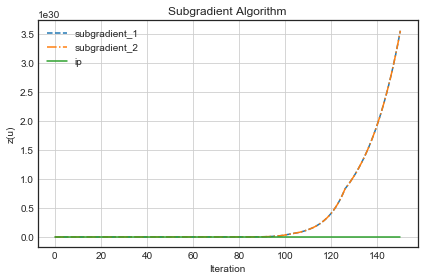

In [13]:
# subgradient bound improvement
def plot_subgradient():    
    fig = plt.figure()    
    z_subgradient = Log.d['z_lr']
    z_subgradient2 = Log.d['z_lr2']
    z_ip = Log.d["z_ip"]
    
    sub1, = plt.plot(z_subgradient, linestyle='--')
    sub2, = plt.plot(z_subgradient2, linestyle='-.')
    ip, = plt.plot(z_ip, linestyle='-')
    plt.xlabel('Iteration')
    plt.ylabel('z(u)')
    plt.title('Subgradient Algorithm')
    plt.legend((sub1,sub2,ip),("subgradient_1", "subgradient_2", "ip"))
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
plot_subgradient()

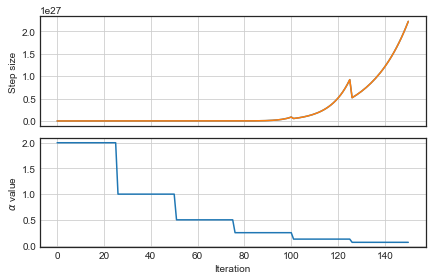

In [14]:
# subgradient step size
def plot_stepsize():
    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
    
    # subgradient step size
    sub1, = ax1.plot(Log.d["step_size"])  
    sub2, = ax1.plot(Log.d["step_size2"])
    ax1.set_ylabel("Step size")
    ax1.grid(True)
    
    # subgradient alpha param
    ax2.plot(Log.d["alpha"]) 
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel(r"$\alpha$ value")
    ax2.grid(True)
    
    fig.tight_layout()
    plt.show()

plot_stepsize()

In [20]:
# Clean up run data
Log.d.clear()

In [49]:
from importlib import reload
import data_utils
reload(data_utils)
instance = data_utils.InstanceData(clients=10, locations=4)

In [50]:
instance.save()
instance.print()

U = 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
C = 
 [[ 8  7  6  9]
 [ 8  3  6  9]
 [10  8  6  0]
 [ 4 10  1 10]
 [ 9  9  0  9]
 [ 0  0  9  4]
 [ 9  4  9  1]
 [ 8  1  3  7]
 [ 6  9  0  6]
 [ 1  8 10  3]]
F = 
 [5, 5, 3, 5, 3, 2, 4, 2, 4, 3]


In [51]:
i = instance.load()
i.print()

U = 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
C = 
 [[ 8  7  6  9]
 [ 8  3  6  9]
 [10  8  6  0]
 [ 4 10  1 10]
 [ 9  9  0  9]
 [ 0  0  9  4]
 [ 9  4  9  1]
 [ 8  1  3  7]
 [ 6  9  0  6]
 [ 1  8 10  3]]
F = 
 [5, 5, 3, 5, 3, 2, 4, 2, 4, 3]
